In [2]:
# %cd ../..

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000 
from PIL import Image, ImageOps
from os import listdir
from os.path import isfile, join
import sys
from tysserand import tysserand as ty

import sys; sys.path.insert(0, '../src/')
import mosna
import seaborn as sns
from time import time
import copy
from skimage import color
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from skimage import io
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp 
import glob
import os
from datetime import datetime
now = datetime.now()


2023-02-13 11:30:39.524519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mounim/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-13 11:30:39.524536: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Data and output dirs

In [4]:
IF_path = Path('../../IMMUcan/data/BRCA/IF') # general output
IMC_path = Path('../../IMMUcan/data/BRCA/IMC_coordiantes/') # general output
clinical_path = Path('../../IMMUcan/data/BRCA/clinical') # general output

network_path = Path('../../IMMUcan/data/BRCA/network') # path to nodes
nodes_path = Path('../../IMMUcan/data/BRCA/nodes') # path to nodes
edges_path = Path('../../IMMUcan/data/BRCA/edges') # path to edges
mixmat_path = Path('../../IMMUcan/data/BRCA/mixmat') # path to mixmats
figures_path = Path('../../IMMUcan/data/BRCA/figures') # path to mixmats
mixmat_zscore_path = Path('../../IMMUcan/data/BRCA/mixmat_zscore') # path to mixmat_zscores
assortavity__path = Path('../../IMMUcan/data/BRCA/assortavity') # path to assortavity
coords_path = IMC_path


# Count cells

38


Text(0.5, 1.0, 'Cell Count Clustermap with 24 features and 38 patients')

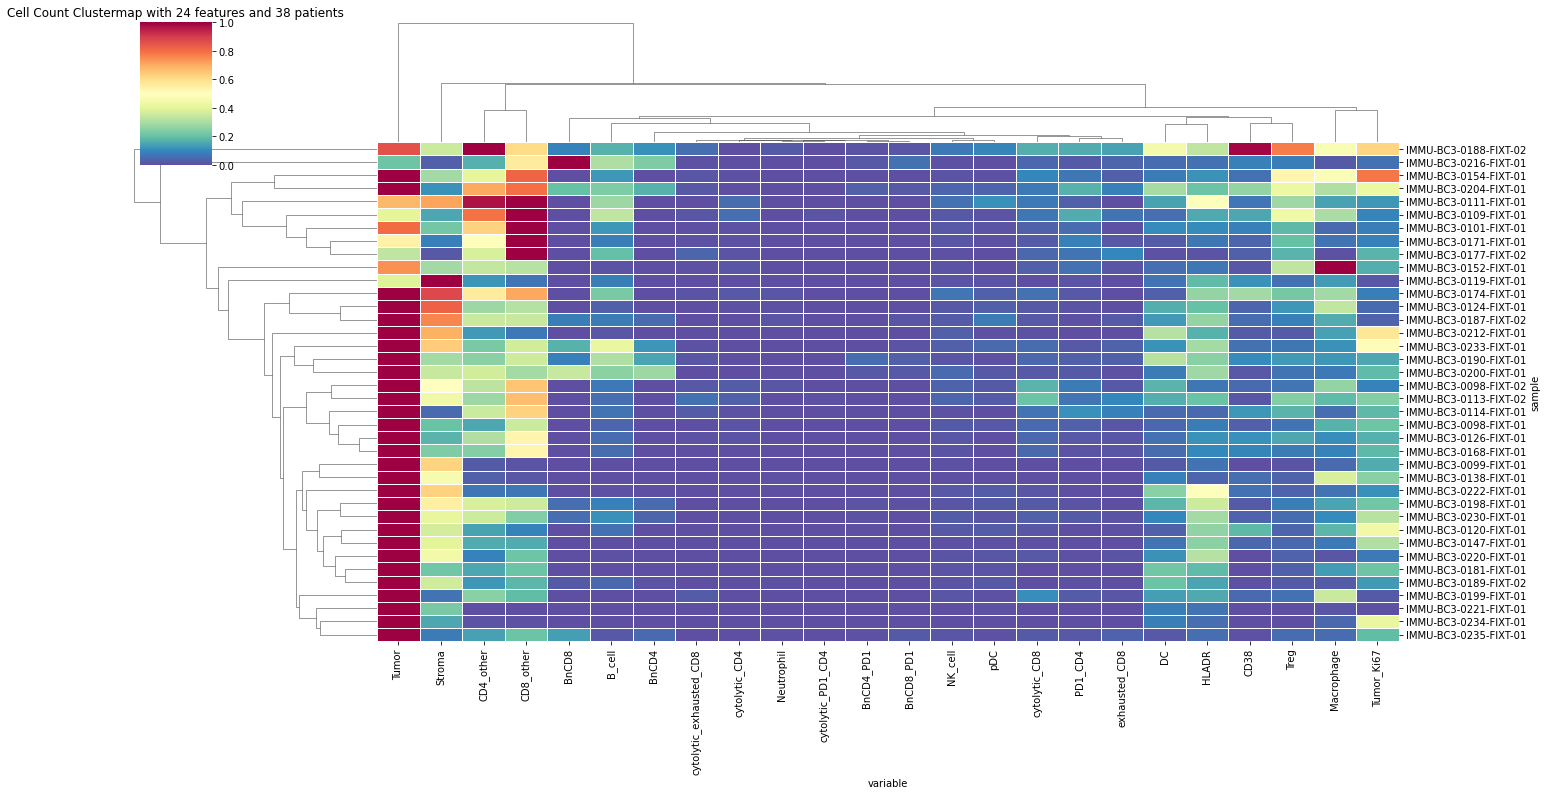

In [5]:
coords_path = IMC_path
p = coords_path.glob('*IMMU*')
files = [x for x in p if (x.is_file()) and ('BC3' in x.stem)]
print(len(files))
# count rows (cell) in each file
cell_types = pd.DataFrame()
for x in files:
    coord_file = x 
    id = x.stem.split('-IM')[0]
    bc = x.stem.split('-')[1]
    try:
        coords = pd.read_csv(coord_file, usecols= ['SampleId','celltypes_layer3'] )
        coords.columns = ['sample', 'celltypes']
        coords['sample']=id
        cell_types = pd.concat([cell_types , coords],axis=0)
    except Exception as E:
        print(id, " FAILED !", E)
    
ValCount = cell_types.value_counts().reset_index()
ValCount.columns = ['sample','variable','Value']
Count = ValCount.pivot_table(index=["sample"], 
                    columns='variable', 
                    values='Value', 
                    fill_value=0)

Count_scld = Count.divide(Count.max(axis=1),axis=0)

sns.clustermap(Count_scld, figsize=[20,11], cmap='Spectral_r',lw=1)
plt.title('Cell Count Clustermap with {} features and {} patients'.format(Count_scld.shape[1] , Count_scld.shape[0]))


# Assortativity

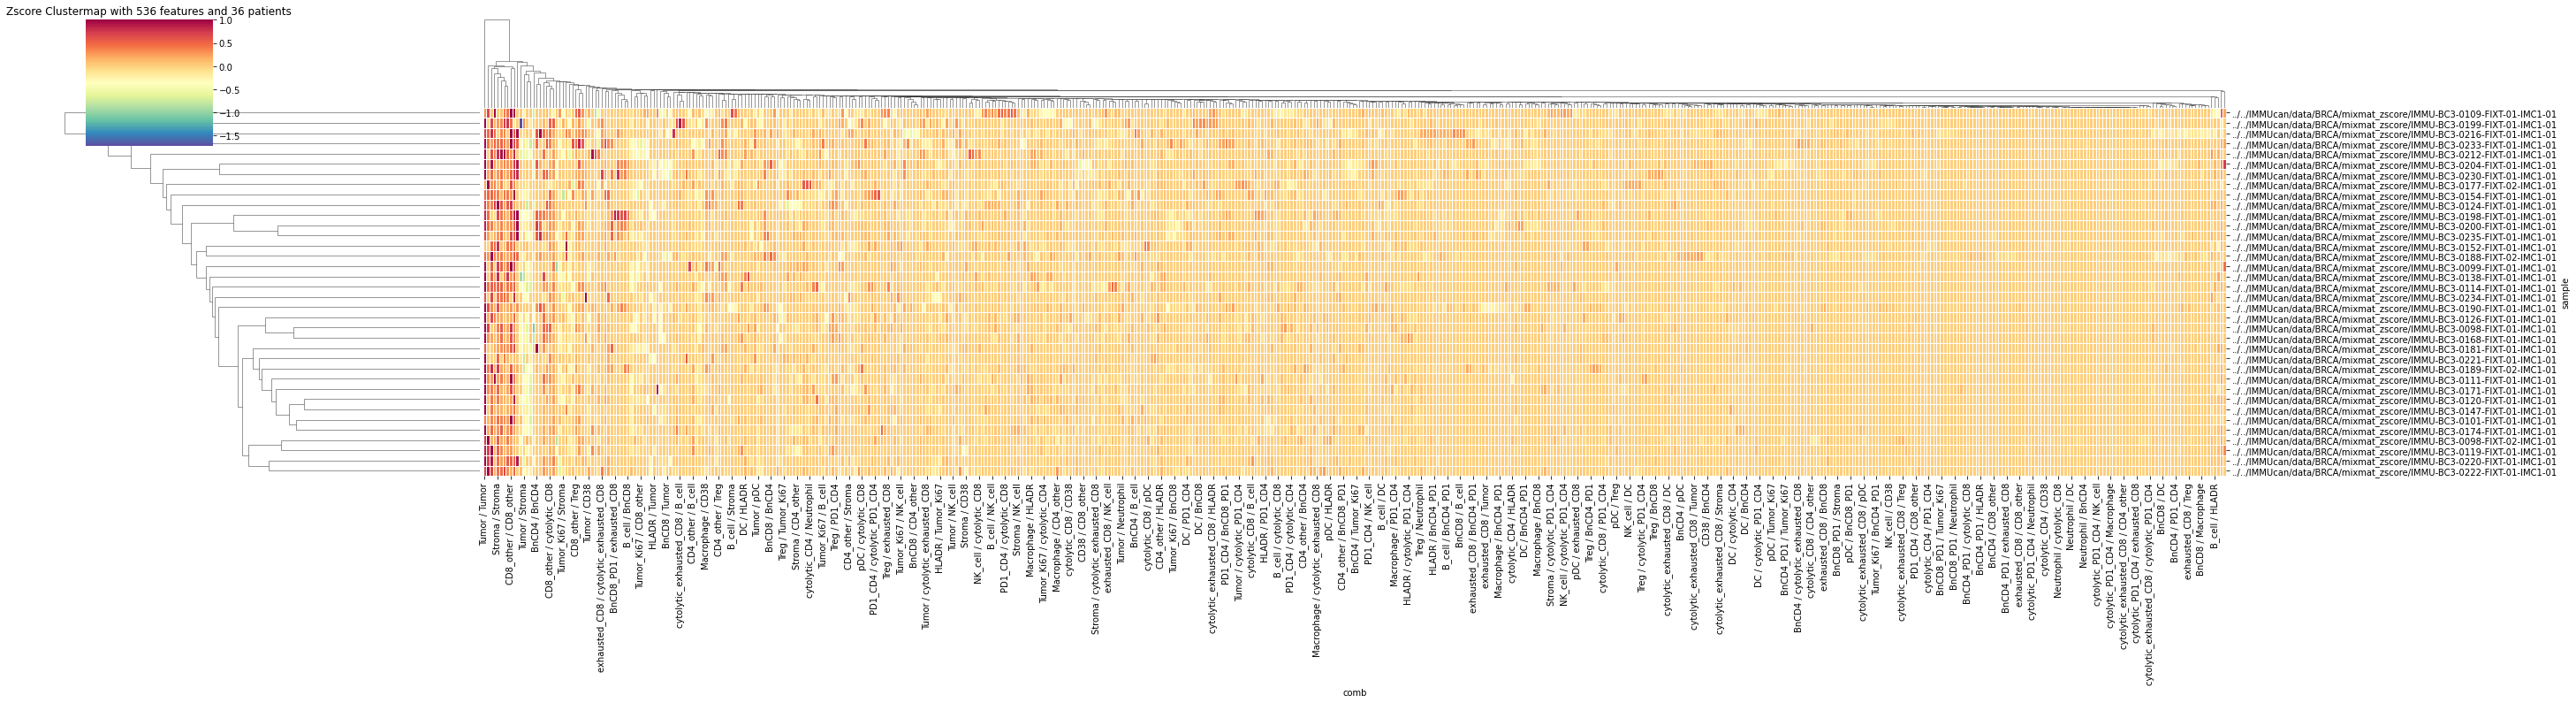

In [6]:

p = mixmat_zscore_path.glob('*IMMU*')
files = [x for x in p if (x.is_file()) and ('BC3' in x.stem)]
files
zscores = pd.DataFrame()
c = 0
zscore_path = mixmat_zscore_path
for filename in files:
    try:
        id = filename
        zscore = pd.read_csv(filename ,index_col=0 ) #read file
        # sns.heatmap(zscore, cmap = "viridis")
        zscore = zscore.fillna(0)
        sns.clustermap(zscore, cmap = "viridis")
        plt.savefig(  figures_path / str('zscore' +  id.stem + '.png')  )
        plt.close()

        zscore_tri = zscore.where(np.triu(np.ones(zscore.shape)).astype(np.bool_))

        MAT = pd.DataFrame(zscore_tri.stack()) # matrix to df (melt)

        MAT.to_csv( 'tmp.csv') #export csv
        MAT = pd.read_csv( 'tmp.csv') # read csv
        MAT.columns = ['X','Y','Value'] # rename cols
        MAT["comb"] = MAT["X"].astype(str) + " / " + MAT["Y"].astype(str)
        MAT['sample']  = id
        zscores = pd.concat([zscores , MAT], axis=0)
        c+=1
    except:
        plt.close()
        pass

assortavity = zscores[['Value', 'comb', 'sample']]

#select specific columns (Remove other)
columns = list(set(assortavity[ ~ assortavity['comb'].str.contains("Other")]['comb'].tolist()))
assortavity_filtred = assortavity[ assortavity['comb'].isin( columns ) ]
### remove comparaison of type to itself


# Df to Matrix
assortavity_filtred = assortavity_filtred.pivot_table(index=["sample"], 
                    columns='comb', 
                    values='Value', 
                    fill_value=0)

markers_combo = assortavity_filtred.columns


assortavity_scld = assortavity_filtred.divide(assortavity_filtred.max(axis=1),axis=0)

sns.clustermap(assortavity_scld, figsize=[40,11], cmap='Spectral_r',lw=1)
plt.title('Zscore Clustermap with {} features and {} patients'.format(assortavity_scld.shape[1] , assortavity_scld.shape[0]))
plt.show()

# NAS

In [7]:
coords_all = pd.DataFrame()
pairs_all = pd.DataFrame()

# Load all coords
p = coords_path.glob('*BC2*')
files = [x for x in p if (x.is_file()) and ('BC2' in x.stem)]
nb_nodes = 0
for sample in files :
    coords = pd.read_csv(sample)
    coords = coords[['Center_X', 'Center_Y','celltypes_layer3']]
    coords['sample'] = sample.stem.split('_#')[0]
    if coords_all.shape[0] <2:
        coords_all = coords
    else:
        nb_nodes += coords.shape[0]
        coords_all = np.vstack([coords_all, coords])
    pairs = pd.read_csv(edges_path/ (sample.stem.split('_#')[0]+'.csv'),index_col=0)
    if pairs_all.shape[0] <1:
        pairs_all = pairs
    else:
        pairs += nb_nodes
        pairs_all = np.vstack([pairs_all, pairs])
    print(coords_all.shape)


coords_all
# pairs_all


(7239, 4)
(12190, 4)
(19675, 4)
(23342, 4)
(30285, 4)
(35423, 4)
(38594, 4)
(44292, 4)
(51200, 4)
(60965, 4)
(68686, 4)
(74536, 4)
(76578, 4)
(81234, 4)
(89700, 4)
(98723, 4)
(102819, 4)
(106322, 4)
(112583, 4)
(118090, 4)
(125487, 4)
(131865, 4)


array([[4.96153846153846, 5.54807692307692, 'CD4_other',
        'IMMU-BC2-0218-FIXT-01-IMC1-01'],
       [23.0, 0.894736842105263, 'CD4_other',
        'IMMU-BC2-0218-FIXT-01-IMC1-01'],
       [31.7706422018349, 6.58715596330275, 'CD4_other',
        'IMMU-BC2-0218-FIXT-01-IMC1-01'],
       ...,
       [19.2903225806452, 597.903225806452, 'NK_cell',
        'IMMU-BC2-0232-FIXT-01-IMC1-01'],
       [251.266666666667, 598.533333333333, 'Tumor',
        'IMMU-BC2-0232-FIXT-01-IMC1-01'],
       [400.0, 599.0, 'B_cell', 'IMMU-BC2-0232-FIXT-01-IMC1-01']],
      dtype=object)

In [261]:
all_edges.loc[(all_edges['source']==index)  , : ]

,source,target


In [8]:
NAS = pd.DataFrame()
#for each cell
c = 0
all_coords = pd.DataFrame(coords_all,columns=['x', 'y','variable','sample']).copy()
all_edges = pd.DataFrame(pairs_all,columns=['source','target']).copy()
for index, row in all_coords.iterrows():
    if sample != row['sample']:
        print('Processing cell number {} / {}...  '.format(c,sample) )
    sample = row['sample']
    if 1:
        sourceIdx = index
        # get targets from all_edges
        targets = []
        targets_edges = all_edges.loc[(all_edges['source']==sourceIdx)  , : ]
        targets += list(targets_edges['target'])
        # get sources from all_edges
        source_edges = all_edges.loc[(all_edges['target']==sourceIdx)  , : ]
        targets += list(source_edges['source'])
        # select rows
        selected_targets = all_coords.iloc[targets,:]
        # filtre by sample
        celltypes = selected_targets['variable'].value_counts(normalize=True)
        if celltypes.sum()> 0.2:
            cell = pd.concat([row,celltypes])
            NAS = pd.concat([NAS, cell],axis=1)
            c+=1
        else:
            pass
    # except Exception as E:
    #     print(c, E)
    #     break
NAS.to_csv('../data/processed/IMMUcanBRCA2/NAS/NAS.csv')

Processing cell number 0 / ../../IMMUcan/data/BRCA/IMC_coordiantes/IMMU-BC2-0232-FIXT-01-IMC1-01_#_cell_metadata_#_065bee638580c18bde12197839b6659b.csv...  
Processing cell number 7239 / IMMU-BC2-0218-FIXT-01-IMC1-01...  
Processing cell number 9902 / IMMU-BC2-0132-FIXT-01-IMC1-01...  
Processing cell number 17141 / IMMU-BC2-0217-FIXT-01-IMC1-01...  
Processing cell number 17683 / IMMU-BC2-0183-FIXT-01-IMC1-01...  
Processing cell number 24626 / IMMU-BC2-0167-FIXT-01-IMC1-01...  
Processing cell number 28866 / IMMU-BC2-0163-FIXT-01-IMC1-01...  
Processing cell number 30407 / IMMU-BC2-0151-FIXT-01-IMC1-01...  
Processing cell number 34895 / IMMU-BC2-0145-FIXT-01-IMC1-01...  
Processing cell number 41472 / IMMU-BC2-0140-FIXT-01-IMC1-01...  
Processing cell number 48711 / IMMU-BC2-0225-FIXT-01-IMC1-01...  
Processing cell number 56432 / IMMU-BC2-0215-FIXT-01-IMC1-01...  
Processing cell number 61434 / IMMU-BC2-0229-FIXT-01-IMC1-01...  
Processing cell number 63476 / IMMU-BC2-0202-FIXT-01-

In [9]:
# NAS = pd.read_csv('../data/processed/IMMUcanBRCA2/NAS/NAS.csv',index_col=0)
Nas = NAS.T.fillna(0)
Nas.head()

,x,y,variable,sample,Tumor,CD8_other,Neutrophil,B_cell,Macrophage,CD4_other,...,PD1_CD4,cytolytic_exhausted_CD8,BnCD4,cytolytic_CD8,pDC,BnCD8,BnCD4_PD1,BnCD8_PD1,cytolytic_CD4,cytolytic_PD1_CD4
0,4.961538,5.548077,CD4_other,IMMU-BC2-0218-FIXT-01-IMC1-01,0.400000,0.400000,0.200000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,23.000000,0.894737,CD4_other,IMMU-BC2-0218-FIXT-01-IMC1-01,0.666667,0.000000,0.333333,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,31.770642,6.587156,CD4_other,IMMU-BC2-0218-FIXT-01-IMC1-01,0.333333,0.166667,0.000000,0.333333,0.166667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,40.813953,1.465116,B_cell,IMMU-BC2-0218-FIXT-01-IMC1-01,0.000000,0.666667,0.000000,0.000000,0.000000,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,50.857923,9.355191,CD8_other,IMMU-BC2-0218-FIXT-01-IMC1-01,0.400000,0.200000,0.000000,0.200000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


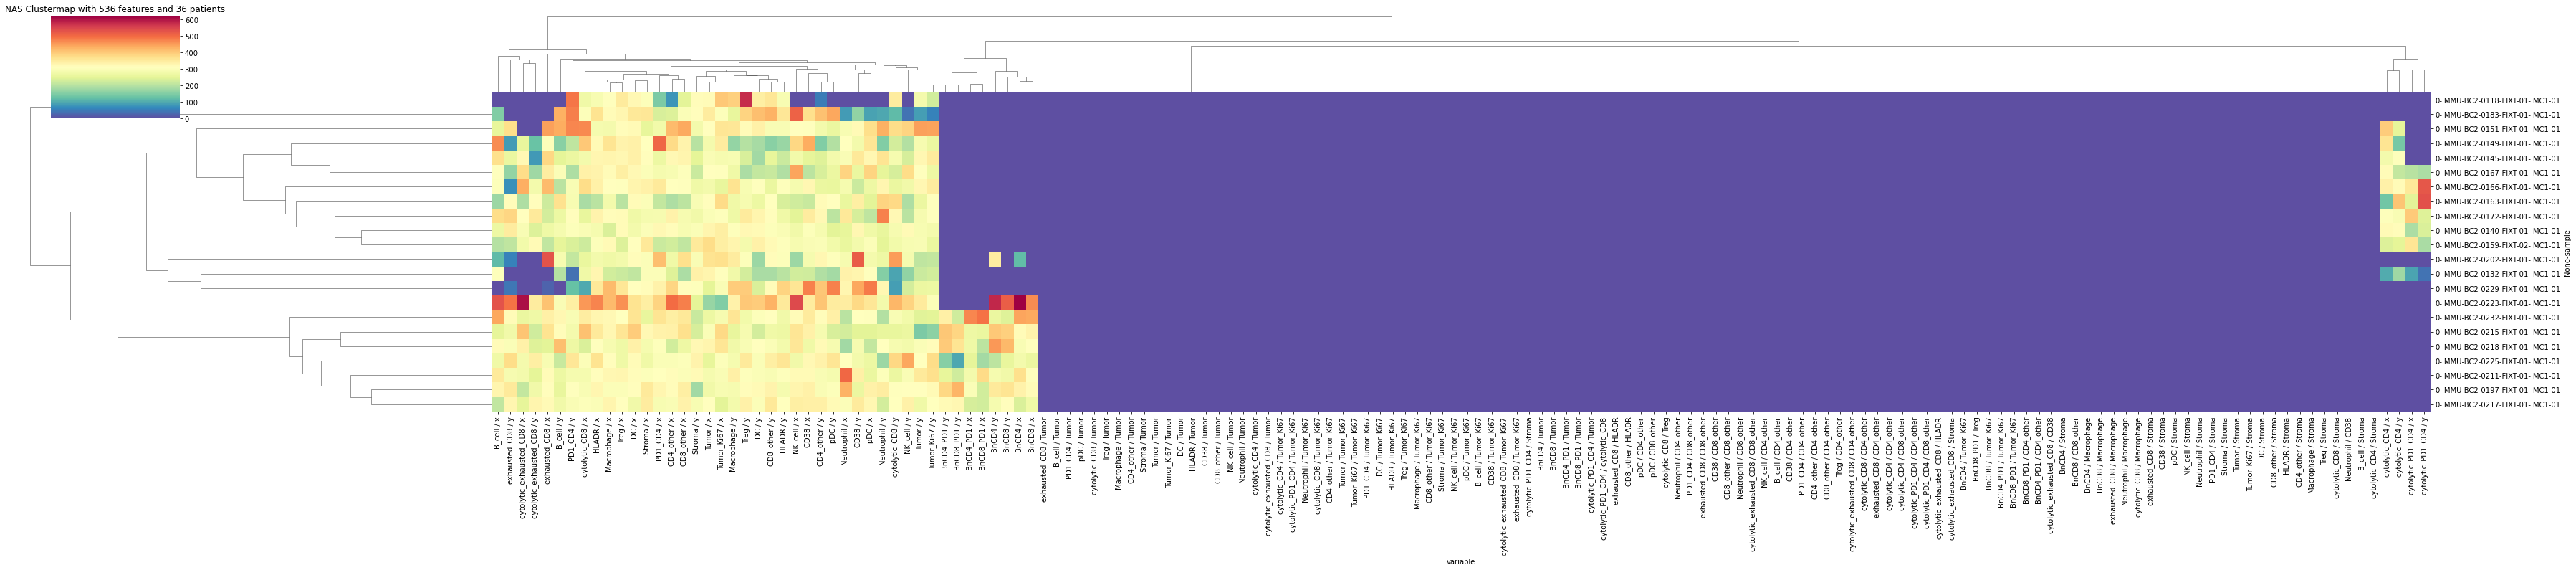

In [10]:
Nas_avg = Nas.groupby(['sample','variable']).mean()
Nas_avg
Nas_Avg = Nas_avg.stack().reset_index()
Nas_Avg['variable'] = Nas_Avg['variable'] + ' / ' + Nas_Avg['level_2']
Nas_Avg = Nas_Avg.drop(columns=['level_2'])
Nas_Avg = pd.pivot_table(Nas_Avg, values=[0], index=['variable'],columns=['sample'])
Nas_Avg = Nas_Avg.fillna(0).T
Nas_Avg = Nas_Avg.loc[:, Nas_Avg.std(axis=0) > Nas_Avg.std(axis=0).quantile(0.75)]

sns.clustermap(Nas_Avg, figsize=[50,11], cmap='Spectral_r')
plt.title('NAS Clustermap with {} features and {} patients'.format(assortavity_scld.shape[1] , assortavity_scld.shape[0]))
plt.show()

In [264]:
Nas = NAS.T.fillna(0)
X = Nas.iloc[:,4:]
y = Nas.iloc[:,3]
y

0    IMMU-BC2-0218-FIXT-01-IMC1-01
0    IMMU-BC2-0218-FIXT-01-IMC1-01
0    IMMU-BC2-0218-FIXT-01-IMC1-01
0    IMMU-BC2-0218-FIXT-01-IMC1-01
0    IMMU-BC2-0218-FIXT-01-IMC1-01
                 ...              
0    IMMU-BC2-0232-FIXT-01-IMC1-01
0    IMMU-BC2-0232-FIXT-01-IMC1-01
0    IMMU-BC2-0232-FIXT-01-IMC1-01
0    IMMU-BC2-0232-FIXT-01-IMC1-01
0    IMMU-BC2-0232-FIXT-01-IMC1-01
Name: sample, Length: 108887, dtype: object

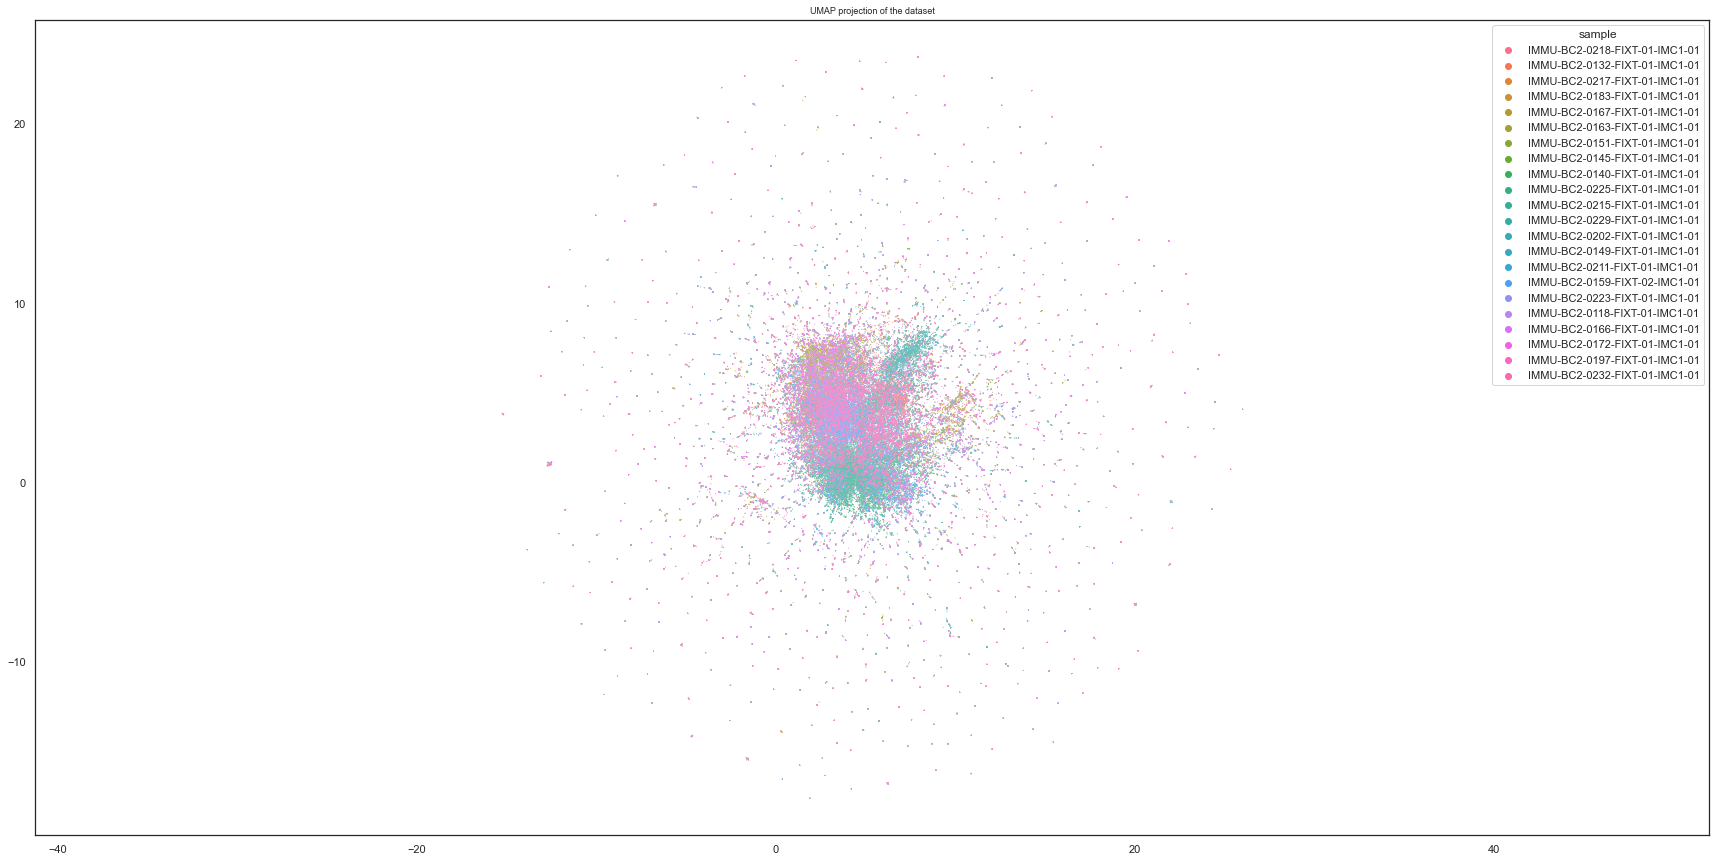

In [266]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(30,15)})
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(X)

sns.scatterplot(
    x = embedding[:, 0],
    y = embedding[:, 1],
    s = 1,
    hue=y
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=9);

In [297]:

color_dict = dict({'CD4_other':'brown',
                  'B_cell':'green',
                  'CD8_other': 'orange',
                  'Tumor': 'red',
                   'Macrophage': 'dodgerblue',
                   'DC': 'cyan',
                   'NK_cell': 'magenta',
                    'DCx':'#BBBBBB', 'BnCD8_PD1':'#BBBBBB', 'exhausted_CD8':'#BBBBBB', 'cytolytic_CD4':'#BBBBBB', 'PD1_CD4':'#BBBBBB', 'Tumor_Ki67':'#BBBBBB', 'cytolytic_exhausted_CD8':'#BBBBBB', 'cytolytic_PD1_CD4':'#BBBBBB', 'BnCD4_PD1':'#BBBBBB', 'pDC':'#BBBBBB', 'CD38':'#BBBBBB', 'HLADR':'#BBBBBB', 'BnCD8':'#BBBBBB', 'Stroma':'#BBBBBB', 'cytolytic_CD8':'#BBBBBB', 'BnCD4':'#BBBBBB', 'Treg':'#BBBBBB', 'NK_cexll':'#BBBBBB', 'Neutrophil':'#BBBBBB',
                   })
dim_clust = 2
min_samples = 10
min_cluster_size = 2000
epsilon = 0.0 # cluster_selection_epsilon=0.0 by default
n_neighbors = 70
metric = 'euclidean'


/home/mounim/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


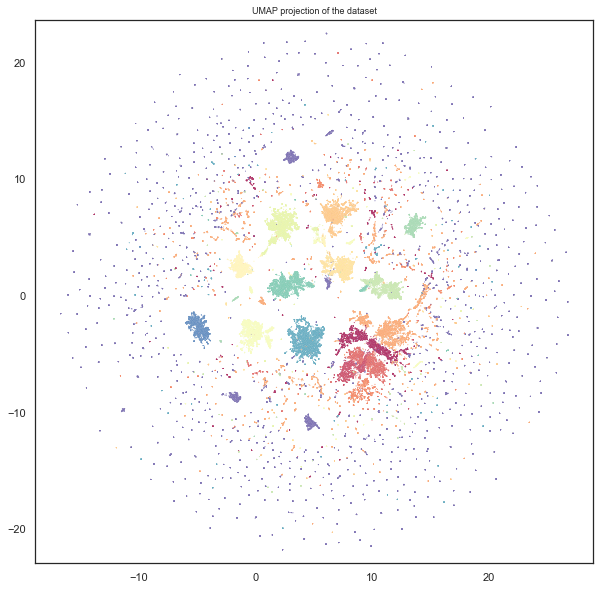

In [305]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(10,10)})
import umap
import sklearn.cluster as cluster
import hdbscan

y = Nas.iloc[:,3]

scaled_X = StandardScaler().fit_transform(X)
# embedding = reducer.fit_transform(scaled_X)

# kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(scaled_X.data)

clusterable_embedding = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=0.0,
    n_components=2,
    metric = metric,
    random_state=0,
    ).fit_transform(scaled_X)

labels = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size, 
    min_samples=min_samples,
    cluster_selection_epsilon=epsilon,
).fit_predict(clusterable_embedding)

clustered = (labels >= 0)


sns.scatterplot(
    embedding[:, 0],
    embedding[:, 1],
    s = 1,
    c=labels,
    cmap='Spectral_r',
    # palette=color_dict,    
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=9);


In [308]:
Nas['Cluster'] = labels
Nas.head()

,x,y,variable,sample,Tumor,CD8_other,Neutrophil,B_cell,Macrophage,CD4_other,...,cytolytic_exhausted_CD8,BnCD4,cytolytic_CD8,pDC,BnCD8,BnCD4_PD1,BnCD8_PD1,cytolytic_CD4,cytolytic_PD1_CD4,Cluster
0,4.961538,5.548077,CD4_other,IMMU-BC2-0218-FIXT-01-IMC1-01,0.400000,0.400000,0.200000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
0,23.000000,0.894737,CD4_other,IMMU-BC2-0218-FIXT-01-IMC1-01,0.666667,0.000000,0.333333,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
0,31.770642,6.587156,CD4_other,IMMU-BC2-0218-FIXT-01-IMC1-01,0.333333,0.166667,0.000000,0.333333,0.166667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
0,40.813953,1.465116,B_cell,IMMU-BC2-0218-FIXT-01-IMC1-01,0.000000,0.666667,0.000000,0.000000,0.000000,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
0,50.857923,9.355191,CD8_other,IMMU-BC2-0218-FIXT-01-IMC1-01,0.400000,0.200000,0.000000,0.200000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14


In [91]:
from statsmodels.multivariate.pca import PCA

pca = PCA(
  data = X,
  standardize = True,
  normalize = True,
  ncomp = 2
)

biplot(
  pca = pca,
  scaling = 2,
  plot_loading_labels = True,
  color = labels
)

NameError: name 'X' is not defined

In [96]:
x = pd.read_csv('~/CRCT-Projects/GEMDeCan_deconvolution/inputs/BC2_ALL_TMP.txt',sep='\t')
x.isna().sum(axis=1)

0        0
1        0
2        0
3        0
4        0
        ..
58671    1
58672    1
58673    1
58674    1
58675    1
Length: 58676, dtype: int64